In [ ]:
import os, math
import pandas as pd3
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# find data files
all_files_name = os.listdir("./data")
data_files_name = [i for i in all_files_name if "hourly.csv" in i]
# read all files
df_list = [pd.read_csv("./data/"+file_name,index_col='Datetime') for file_name in data_files_name]
print(f"{len(df_list)} files loaded.")

FileNotFoundError: ignored

In [ ]:
# print summary of the power consumption
sample = [i.describe() for i in df_list]
pd.concat(sample, axis = 1)

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW,PJM_Load_MW
count,121273.000000,66497.000000,121275.000000,57739.000000,116189.000000,119068.000000,45334.000000,62874.000000,58450.000000,145366.000000,143206.000000,32896.000000
mean,15499.513717,11420.152112,2037.851140,3105.096486,10949.203625,1658.820296,1464.218423,7792.159064,11701.682943,32080.222831,5602.375089,29766.427408
std,2591.399065,2304.139517,393.403153,599.859026,2413.946569,301.740640,378.868404,1331.268006,2371.498701,6464.012166,979.142872,5849.769954
min,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,14544.000000,487.000000,17461.000000
25%,13630.000000,9780.000000,1749.000000,2687.000000,9322.000000,1444.000000,1185.000000,6807.000000,9954.000000,27573.000000,4907.000000,25473.000000
50%,15310.000000,11152.000000,2009.000000,3013.000000,10501.000000,1630.000000,1386.000000,7700.000000,11521.000000,31421.000000,5530.000000,29655.000000
75%,17200.000000,12510.000000,2279.000000,3449.000000,12378.000000,1819.000000,1699.000000,8556.000000,12896.750000,35650.000000,6252.000000,33073.250000
max,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,62009.000000,9594.000000,54030.000000


In [ ]:
# get PJME consumption
df = df_list[-3]
df['date'] = [i[0:10] for i in df.index]
df_date = df.groupby(['date']).mean()

In [ ]:
# We only want the last 6 years 
# The data I can add to it, 
df_date = df_date[df_date.index >= "2012-01-01"] # 
df_train, df_test = df_date[df_date.index < "2018-01-01"].values, \
                    df_date[df_date.index >= "2018-01-01"].values
print(f"train shape: {df_train.size} test shape: {df_test.size}")

train shape: 2192 test shape: 215


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

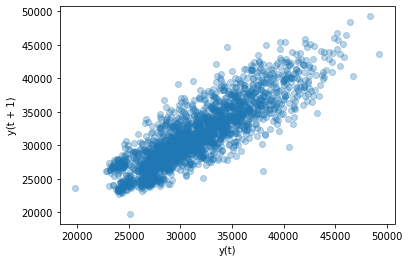

In [ ]:
# autocorrelation check
from pandas.plotting import lag_plot
lag_plot(df_date[df_date.index < "2018-01-01"], alpha=0.3)

The MAPE for the test set is: 14.92%


Text(0, 0.5, 'Electricity Consumption (MW)')

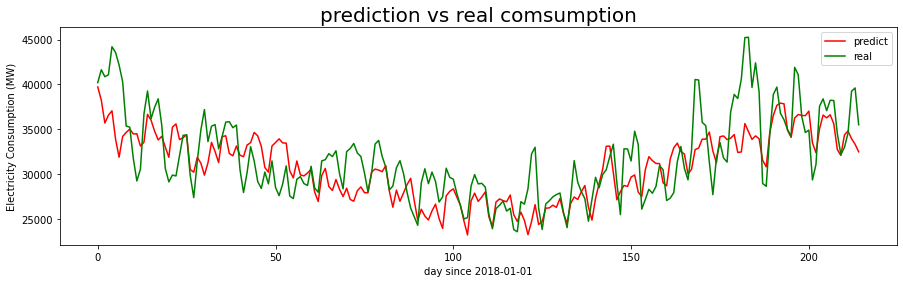

In [ ]:
# training
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
model = AutoReg(df_train, lags=370, trend='ct', old_names = False)
model = model.fit()
# predict on test data
prediction = model.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
# compute the MAPE = mean(abs( (true - predict) / true))
MAPE = np.mean(np.fabs((df_test - prediction ) / df_test))
print(f"The MAPE for the test set is: {MAPE*100:.2f}%")

# plot picture on test set.
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(range(len(df_test)), prediction, 'red')
ax.plot(range(len(df_test)), df_test, 'green')
ax.legend(['predict','real'])
ax.set_title('prediction vs real comsumption',fontsize=20)
ax.set_xlabel('day since 2018-01-01')
ax.set_ylabel('Electricity Consumption (MW)')

The MAPE for the test set is: 12.75%


Text(0, 0.5, 'Electricity Consumption (MW)')

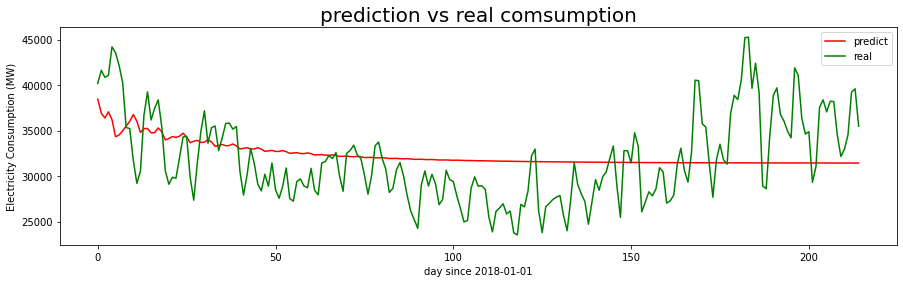

In [ ]:
var = ar_select_order(df_train, 1000, old_names=False)
var.ar_lags
model_2 = var.model.fit()
prediction = model_2.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
# compute the MAPE = mean(abs( (true - predict) / true))
MAPE = np.mean(np.fabs((df_test - prediction ) / df_test))
print(f"The MAPE for the test set is: {MAPE*100:.2f}%")

# plot picture on test set.
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(range(len(df_test)), prediction, 'red')
ax.plot(range(len(df_test)), df_test, 'green')
ax.legend(['predict','real'])
ax.set_title('prediction vs real comsumption',fontsize=20)
ax.set_xlabel('day since 2018-01-01')
ax.set_ylabel('Electricity Consumption (MW)')

In [ ]:
# find out the lag system choose.
var.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])